In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

**Data Preprocessing**

We will load the dataset, split it into training and validation sets, resize images to 150x150, normalize the pixel values, and apply data augmentation.

Randomly modify the training images by:
Rotating.
Zooming.
Flipping horizontally.

 These small changes make the model more robust by teaching it to recognize images even when they are slightly rotated, zoomed, or flipped.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = '/content/drive/My Drive/chest_xray/chest_xray/train'
val_dir = '/content/drive/My Drive/chest_xray/chest_xray/val'
test_dir = '/content/drive/My Drive/chest_xray/chest_xray/test'

In [ ]:
img_height = 150
img_width = 150
batch_size = 32

In [ ]:
# Load images from directories
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,   # Path to the directory containing training images
    color_mode='grayscale', # Load images in grayscale mode (1 channel instead of 3 RGB channels)
    image_size=(img_height, img_width),
    batch_size=batch_size   # Number of images in each batch
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,  # Path to the directory containing validation images
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size  # Process validation images in batches
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Path to the directory containing test images
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size

)

Found 5449 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# Normalize pixel values and apply data augmentation to training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only normalize validation and test data
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

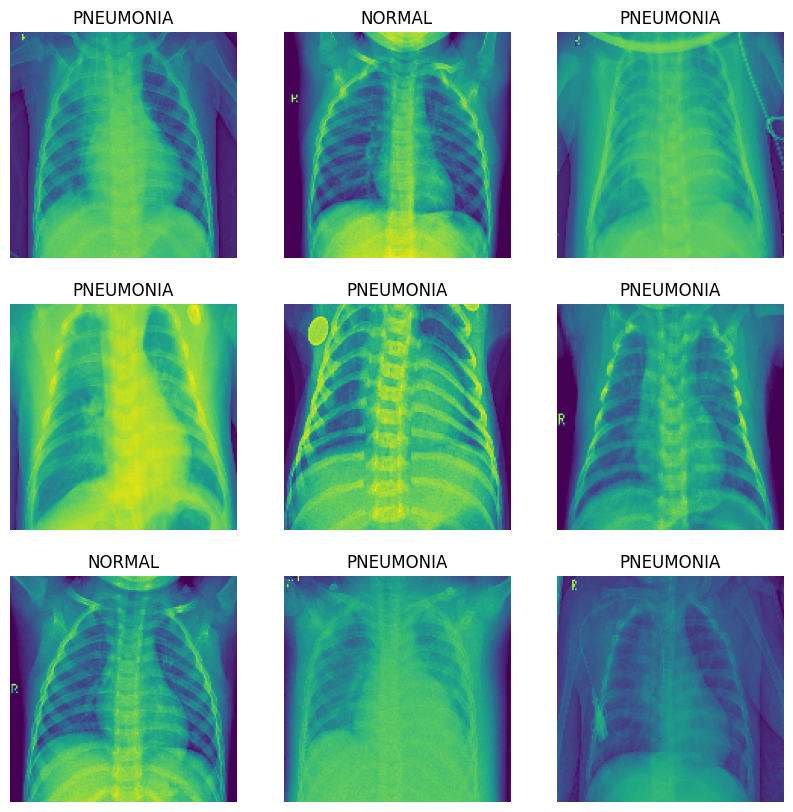

In [ ]:
plt.figure(figsize=(10, 10))  #Set the figure size to 10x10 inches
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots for displaying images
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        plt.title(train_ds.class_names[labels[i]])         # Set the title of the subplot to the corresponding label
        plt.axis("off") # Turn off the axis for better visualization

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

 CNN Model Construction

Explanation:
A CNN processes image data effectively using convolutional layers for feature extraction.

The architecture involves:

Convolutional layers: Extract spatial features.

Pooling layers: Downsample the feature maps.

Dropout: Prevent overfitting.

Dense layers: Combine features for classification.

In [ ]:
# CNN model
model = tf.keras.Sequential([
# 1st Convolutional Layer: Extracts 32 feature maps using a 3x3 filter size.
    # Activation function: ReLU (Rectified Linear Unit) adds non-linearity.
    # Input shape: 150x150 pixels with 1 channel (grayscale images).
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    layers.MaxPooling2D(2,2), # 1st MaxPooling Layer:
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2), # 2nd MaxPooling Layer:
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(), # Flatten Layer: Converts the 2D feature maps into a 1D vector for input to fully connected layers.
    Dropout(0.5),    # Dropout Layer: Randomly drops 50% of the nodes during training to prevent overfitting.
    layers.Dense(128, activation='relu'),     # Fully Connected (Dense) Layer: Contains 128 neurons with ReLU activation for further learning.
    layers.Dense(1, activation='softmax')     # Output Layer: Contains 1 neuron with softmax activation for binary classification (e.g., Normal vs. Pneumonia).

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

**Train the Model with Regularization**

We will add Dropout and implement Early Stopping to monitor the validation loss during training.

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1156s 7s/step - accuracy: 0.2474 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2474 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2474 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2474 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2474 - loss: nan - val_accuracy: 0.5000 - val_loss: nan


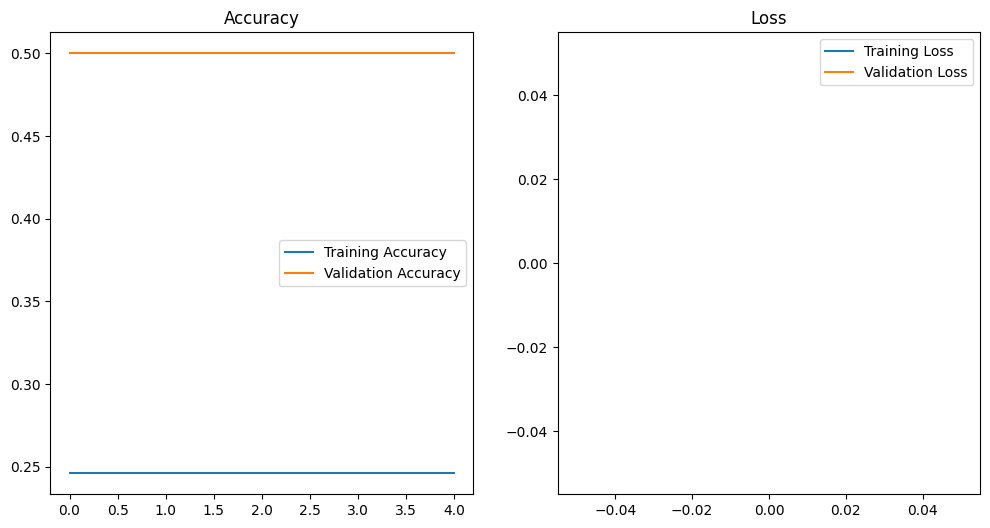

In [ ]:


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history=  model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,

    callbacks=[early_stopping] #add early stopping callback
)

# Plot training history
import matplotlib.pyplot as plt

# Accuracy and loss plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


**Pretrained Models and Transfer Learning**

Explanation:

Transfer learning uses a pretrained model (like VGG16, ResNet50) to save training time and improve performance.

Steps:
Remove the top layers of the pretrained model.

Add new layers for binary classification.

Freeze initial layers for early training and unfreeze for fine-tuning.

In [ ]:
from tensorflow.keras.layers import Rescaling
def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    return image, label

# Apply grayscale to RGB conversion and normalize pixel values
train_ds = train_ds.map(grayscale_to_rgb).map(lambda x, y: (Rescaling(1.0 / 255)(x), y))
val_ds = val_ds.map(grayscale_to_rgb).map(lambda x, y: (Rescaling(1.0 / 255)(x), y))

# Load pretrained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom classification layers
vgg_custom_model = tf.keras.Sequential([
    vgg_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
vgg_custom_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history= vgg_custom_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.8831 - loss: 0.2778 - val_accuracy: 0.7500 - val_loss: 0.6001
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.9644 - loss: 0.1036 - val_accuracy: 0.7500 - val_loss: 0.6629
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9689 - loss: 0.0880 - val_accuracy: 0.6250 - val_loss: 0.8967
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9735 - loss: 0.0804 - val_accuracy: 0.7500 - val_loss: 0.6364
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9742 - loss: 0.0687 - val_accuracy: 0.7500 - val_loss: 0.5301
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9781 - loss: 0.0626 - val_accuracy: 0.6250 - val_loss: 1.1081
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9770 - loss: 0.0664 - val_accuracy: 0.8125 - val_loss: 0.4860
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9783 - loss: 0.0543 -

In [ ]:
# Compare performance
print("Custom Model Accuracy:", max(history.history['val_accuracy']))
print("VGG16 Model Accuracy:", max(history.history['val_accuracy']))

**Model Performance Comparison**

We compare the performance of the custom CNN, VGG16, and ResNet50 models in terms of accuracy and loss.

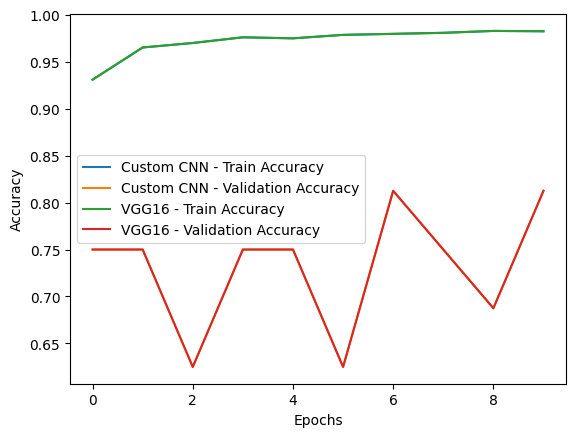

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Custom CNN - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Custom CNN - Validation Accuracy')
plt.plot(history.history['accuracy'], label='VGG16 - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='VGG16 - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Report Findings**

Custom CNN Model:
Simpler architecture with reasonable accuracy but prone to overfitting.

VGG16:
Performs better due to pre-trained features but requires careful fine-tuning.

Impact of Techniques:

Data Augmentation: Improved generalization by simulating diverse conditions.

Dropout: Reduced overfitting by preventing co-adaptation of neurons.

Transfer Learning: Boosted accuracy significantly by leveraging pre-trained knowledge.